<a href="https://colab.research.google.com/github/Debanil1986/Joint-Multipathpp_testing/blob/master/NN_(2)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Normalization stats:
Mean: tensor([-5699.4873,  8023.7510])
Std: tensor([601.8121, 847.6780])
History range before norm: -5771.21 to 8124.70
History range after norm: -0.12 to 0.12


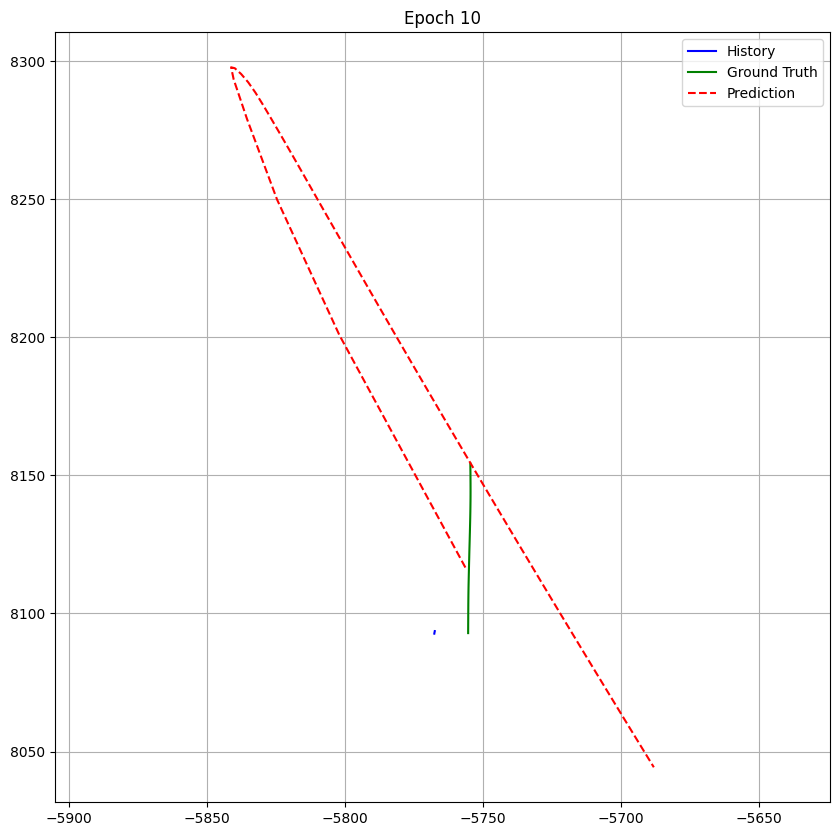

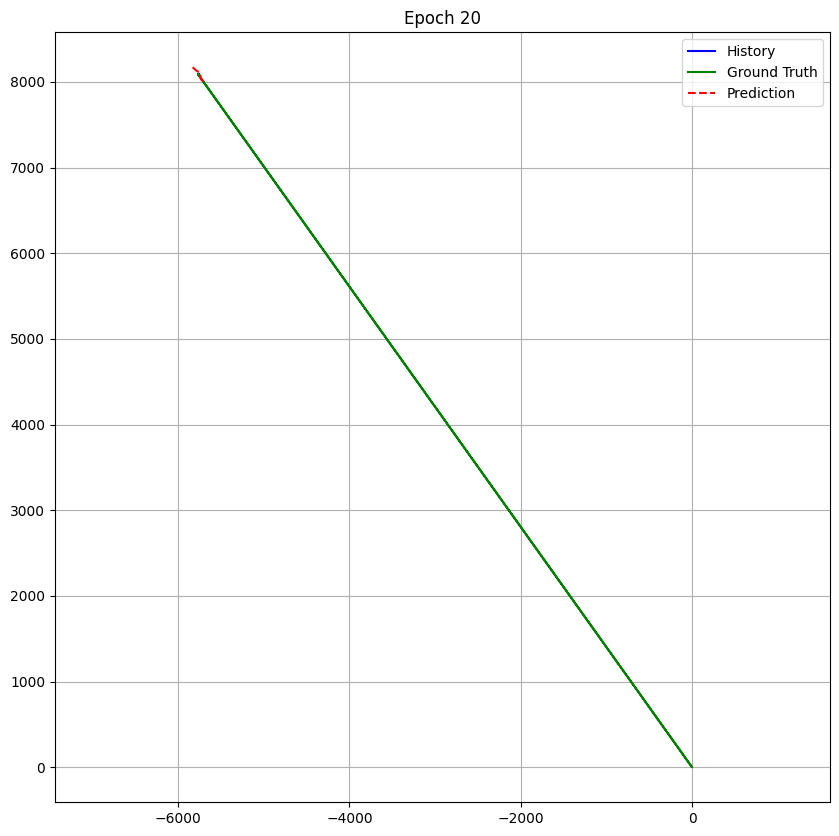

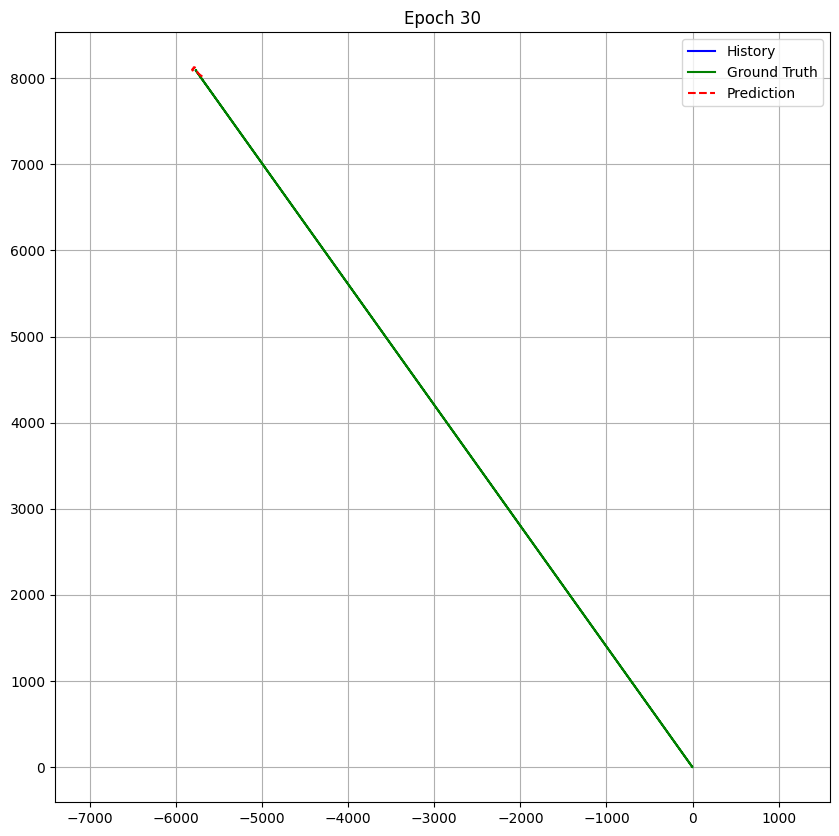

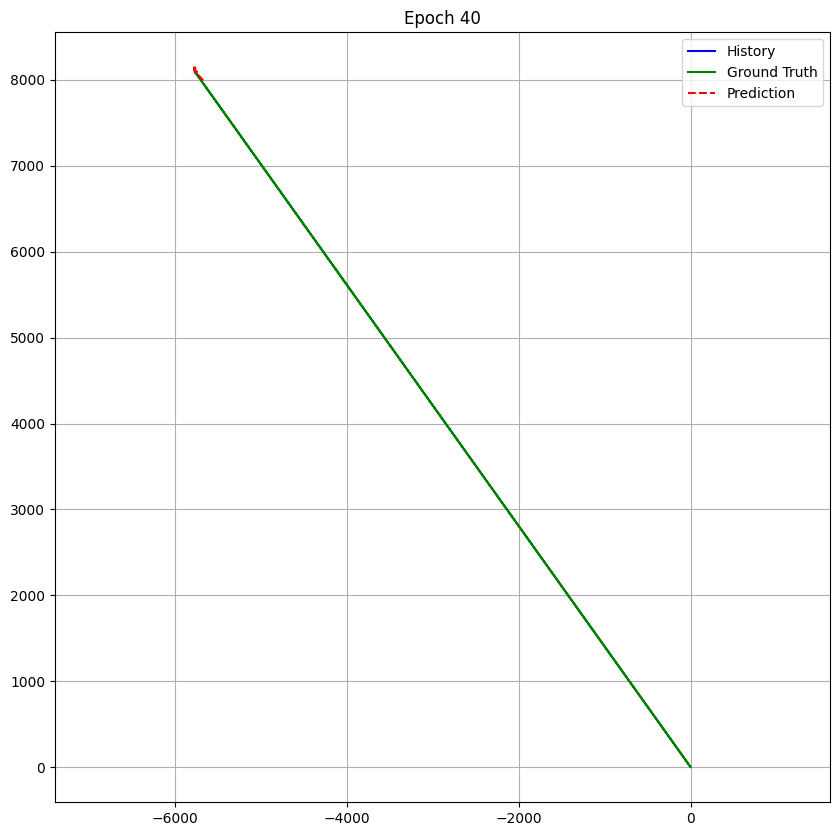

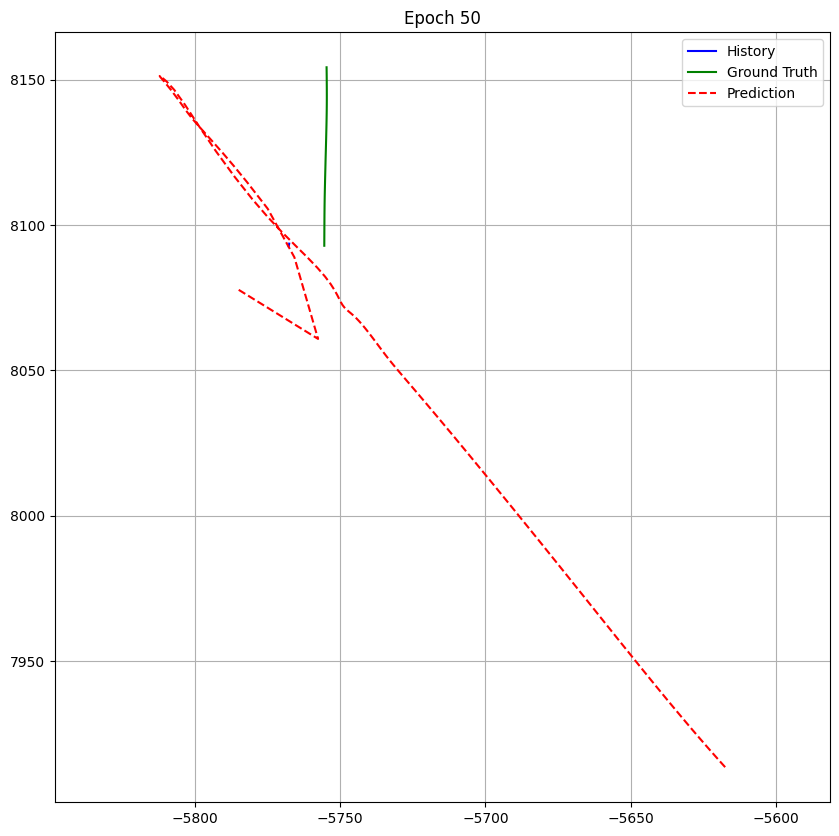

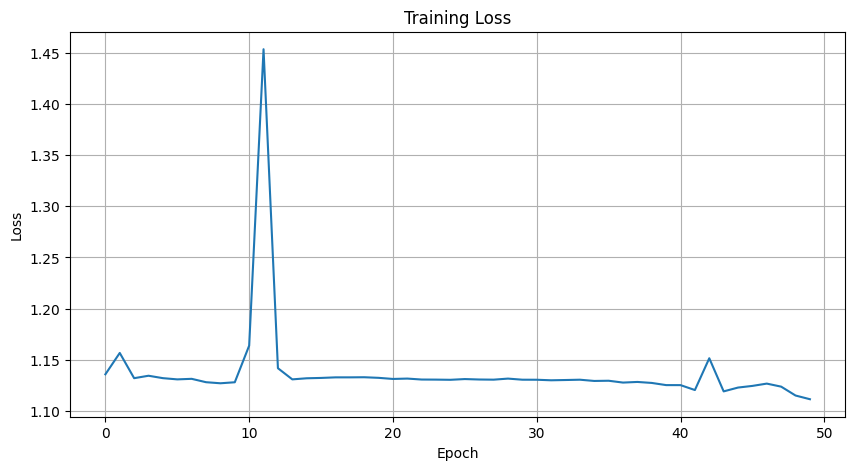

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

class TrajectoryDataset(Dataset):
    def __init__(self, data_path):
        data = np.load(data_path)

        valid_mask = data['agent_valid'].astype(bool)

        # Store original data
        self.history = torch.FloatTensor(data['history/xy'][valid_mask])
        self.future = torch.FloatTensor(data['future/xy'][valid_mask])
        self.history_valid = torch.FloatTensor(data['history/valid'][valid_mask])
        self.future_valid = torch.FloatTensor(data['future/valid'][valid_mask])

        # Compute statistics only on valid points
        valid_history = self.history[self.history_valid.bool()]
        valid_future = self.future[self.future_valid.bool()]

        # Compute mean and std across all valid points
        all_valid_points = torch.cat([valid_history, valid_future], dim=0)
        self.mean = all_valid_points.mean(dim=0)
        self.std = all_valid_points.std(dim=0)

        # Add small epsilon to avoid division by zero
        self.std = torch.where(self.std < 1e-6, torch.ones_like(self.std), self.std)

        # Normalize
        self.history_normalized = (self.history - self.mean) / self.std
        self.future_normalized = (self.future - self.mean) / self.std

        print("Normalization stats:")
        print(f"Mean: {self.mean}")
        print(f"Std: {self.std}")
        print(f"History range before norm: {self.history.min():.2f} to {self.history.max():.2f}")
        print(f"History range after norm: {self.history_normalized.min():.2f} to {self.history_normalized.max():.2f}")

    def __len__(self):
        return len(self.history)

    def __getitem__(self, idx):
        return ((self.history_normalized[idx], self.history_valid[idx]),
                (self.future_normalized[idx], self.future_valid[idx]))

    def denormalize(self, data):
        """Denormalize data back to original scale"""
        return data * self.std + self.mean




class TrajectoryPredictor(nn.Module):
    def __init__(self, hidden_size=128):
        super().__init__()

        self.encoder = nn.LSTM(
            input_size=2,  # x, y coordinates
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )

        self.decoder = nn.LSTM(
            input_size=2,
            hidden_size=hidden_size,
            num_layers=2,
            batch_first=True,
            dropout=0.3
        )

        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x, teacher_forcing_ratio=0.5):
        # x shape: [batch, 11, 2]
        batch_size = x.size(0)

        # Encode history
        hidden, state = self.encoder(x)

        # Initialize decoder input as last position
        decoder_input = x[:, -1:, :]  # shape: [batch, 1, 2]

        # Collect outputs
        outputs = []

        # Generate future trajectory
        for t in range(80):  # 80 future timesteps
            # Get decoder output
            out, state = self.decoder(decoder_input, state)
            prediction = self.fc(out)
            outputs.append(prediction)

            # Next input is prediction
            decoder_input = prediction

        return torch.cat(outputs, dim=1)

def train_model(model, train_loader, epochs=50, lr=0.01):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch_idx, ((hist, hist_valid), (fut, fut_valid)) in enumerate(train_loader):
            hist, fut = hist.to(device), fut.to(device)
            hist_valid = hist_valid.to(device)
            fut_valid = fut_valid.to(device)

            optimizer.zero_grad()

            # Forward pass
            pred = model(hist)

            # Calculate loss only on valid points
            loss = criterion(pred * fut_valid.unsqueeze(-1), fut * fut_valid.unsqueeze(-1))

            # Backward pass
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        if (epoch + 1) % 10 == 0:
            model.eval()
            with torch.no_grad():
                hist, fut = next(iter(train_loader))[0][0][:1].to(device), next(iter(train_loader))[1][0][:1].to(device)
                pred = model(hist)

                # Denormalize for visualization
                hist_denorm = train_loader.dataset.denormalize(hist.cpu())
                fut_denorm = train_loader.dataset.denormalize(fut.cpu())
                pred_denorm = train_loader.dataset.denormalize(pred.cpu())

                hist_denorm = hist_denorm.numpy()
                fut_denorm = fut_denorm.numpy()
                pred_denorm = pred_denorm.numpy()

                plt.figure(figsize=(10, 10))
                plt.plot(hist_denorm[0, :, 0], hist_denorm[0, :, 1], 'b-', label='History')
                plt.plot(fut_denorm[0, :, 0], fut_denorm[0, :, 1], 'g-', label='Ground Truth')
                plt.plot(pred_denorm[0, :, 0], pred_denorm[0, :, 1], 'r--', label='Prediction')
                plt.legend()
                plt.title(f'Epoch {epoch+1}')
                plt.grid(True)
                plt.axis('equal')
                plt.show()
    torch.save(model.state_dict(), 'trajectory_model.pth')
    return model, losses

def main():
    # Load and prepare data
    dataset = TrajectoryDataset('/content/processed_uncompressed_tf_example_training_training_tfexample.tfrecord-00000-of-01000.npz')
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

    # Create and train model
    model = TrajectoryPredictor()
    model, losses = train_model(model, train_loader)

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
pip install --upgrade pip

In [ ]:
pip install git+https://github.com/waymo-research/waymax.git@main#egg=waymo-waymax

  Cloning https://github.com/waymo-research/waymax.git (to revision main) to /tmp/pip-install-n6qfwt0k/waymo-waymax_159a771e6e80437d954cff0f2e41f135
  Running command git clone --filter=blob:none --quiet https://github.com/waymo-research/waymax.git /tmp/pip-install-n6qfwt0k/waymo-waymax_159a771e6e80437d954cff0f2e41f135
  Resolved https://github.com/waymo-research/waymax.git to commit 720f9214a9bf79b3da7926497f0cd0468ca3e630
  Preparing metadata (setup.py) ... done


In [ ]:
from waymax import config
from waymax import dataloader

scenarios = dataloader.simulator_state_generator(config.WOD_1_1_0_TRAINING)
scenario = next(scenarios)

In [ ]:
%%capture
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses

from waymax import config as _config
from waymax import dataloader
from waymax import datatypes
from waymax import visualization

In [ ]:
# Copyright 2023 The Waymax Authors.
#
# Licensed under the Waymax License Agreement for Non-commercial Use
# Use (the "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#     https://github.com/waymo-research/waymax/blob/main/LICENSE
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Configs for Waymax Environments."""
import dataclasses
import enum
from typing import Optional, Sequence


class CoordinateFrame(enum.Enum):
  """Coordinate system used for data."""

  # All objects are centered at SDC's xy and use SDC's yaw as x-axis.
  SDC = 'SDC'
  # Centered at each object's xy and use their yaws as x-axis.
  OBJECT = 'OBJECT'
  # Uses global coordinates defined in Waymo Open Motion Dataset (WOMD).
  GLOBAL = 'GLOBAL'


class DataFormat(enum.Enum):
  """Data format for serialized records."""

  TFRECORD = 'TFRECORD'


@dataclasses.dataclass(frozen=True)
class DatasetConfig:
  """Configs for dataset/dataloader.

  Attributes:
    path: Path/pattern for data, supporting sharded files with @.
    data_format: The format of data in `path`, string from
      womd_dataloader.DataFormat.
    repeat: Number of times to repeat the dataset. Set None to repeat
      infinitely.
    batch_dims: Batch dimensions in tuple format. Can be empty as ().
    shuffle_seed: Random seed. Set None to disable shuffle.
    shuffle_buffer_size: Buffer size for shuffling.
    num_shards: Number of shards for parallel loading, no effect on data
      returned.
    deterministic: Whether to use deterministic parallel processing.
    include_sdc_paths: Whether to include all valid future paths for SDC
      according to roadgraph connectivity from its starting position.
    aggregate_timesteps: Whether to aggregate keys from tf examples, need to set
      to True for parsing SimulatorState afterwards.
    max_num_rg_points: Max number of roadgraph points in data.
    max_num_objects: Max number of total objects in the scene. Set None to
      include all objects from the data.
    num_paths: Number of roadgraph traversal paths. Must be specified if
      include_sdc_paths is True.
    num_points_per_path: Number of points per roadgraph traversal path. Must be
      specified if include_sdc_paths is True.
    drop_remainder: Argument for tf.data.Dataset.batch. Set True to drop
      remainder if the last batch does not contain enough examples. Note
      training should not be affected since it is looping over all data for
      multiple epochs. For evaluation, it should be set to False to include all
      examples.
    tf_data_service_address: A string or a tuple indicating how to connect to
      the tf.data service. Used as the `service` argument for
      tf.data.experimental.service.distribute in dataloader.
    distributed: If True, the generated data batch will have an extra leading
      axis corresponding to the number of available devices. This is needed when
      the returned data is consumed by a pmap function.
    batch_by_scenario: If True, one example in a returned batch is the entire
      scenario containing all objects; if False, the dataset will treat
      individual object trajectories as a training example rather than an entire
      scenario.
  """

  path: str
  data_format: DataFormat = DataFormat.TFRECORD
  repeat: Optional[int] = None
  batch_dims: tuple[int, ...] = ()
  shuffle_seed: Optional[int] = None
  shuffle_buffer_size: int = 1_000
  num_shards: int = 4
  deterministic: bool = True
  include_sdc_paths: bool = False
  aggregate_timesteps: bool = True
  max_num_rg_points: int = 30000
  max_num_objects: Optional[int] = None
  num_paths: Optional[int] = None
  num_points_per_path: Optional[int] = None
  drop_remainder: bool = True
  tf_data_service_address: Optional[str] = None
  distributed: bool = False
  batch_by_scenario: bool = True


@dataclasses.dataclass(frozen=True)
class ObservationConfig:
  """Config for the built-in Waymax Observation function.

  Attributes:
    num_steps: Number of trajectory history steps for observation.
    roadgraph_top_k: Number of closest roadgraph elements to get for
      observation.
    coordinate_frame: What coordinate frame the observation is using.
  """

  num_steps: int = 1
  roadgraph_top_k: int = 2000
  coordinate_frame: CoordinateFrame = CoordinateFrame.GLOBAL


@dataclasses.dataclass(frozen=True)
class MetricsConfig:
  """Config for the built-in Waymax Metrics functions.

  Attributes:
    metrics_to_run: A list of metric names to run. Available metrics are:
      log_divergence, overlap, offroad, sdc_wrongway, sdc_off_route,
      sdc_progression, kinematic_infeasibility. Additional custom metrics can be
      registered with `metric_factory.register_metric`.
  """
  metrics_to_run: tuple[str, ...] = ('log_divergence', 'overlap', 'offroad')


@dataclasses.dataclass(frozen=True)
class LinearCombinationRewardConfig:
  """Config listing all metrics and their corresponding weights.

  Attributes:
    rewards: Dictionary of metric names to floats indicating the weight of each
      metric to create a reward of a linear combination.
  """

  rewards: dict[str, float]


class ObjectType(enum.Enum):
  """Types of objects that can be controlled by Waymax."""

  SDC = 'SDC'  # The ego-vehicle.
  MODELED = 'MODELED'  # tracks_to_predict objects defined in WOMD.
  VALID = 'VALID'  # All valid objects in the scene.
  NON_SDC = 'NON_SDC'  # Any objects expect the SDC (ego-vehicle).


class SimAgentType(enum.Enum):
  """Types of sim agents that can be used by Waymax."""

  IDM = 'IDM'  # Intelligent driver model.


@dataclasses.dataclass(frozen=True)
class SimAgentConfig:
  """Config for sim agents.

  Attributes:
    agent_type: What sim agent algorithm to use.
    controlled_objects: Which objects the sim agent should control.
  """

  agent_type: SimAgentType
  controlled_objects: ObjectType


@dataclasses.dataclass(frozen=True)
class EnvironmentConfig:
  """Configs for Waymax Environments.

  Attributes:
    max_num_objects: Max number of objects in the scene, should be consistent
      with DatasetConfig.max_num_objects.
    init_steps: Initial/warmup steps taken for the environment. For WOMD, this
      includes 10 warmup steps and 1 for the current step
    controlled_object: What type of objects are controlled.
    compute_reward: Whether to compute the reward. Computing the reward is
      expensive and unnecessary for cases like rollout data generation.
    allow_new_objects_after_warmup: Whether to allow new objects to appear after
      environment warmup. If this is set to `False`, all non-controlled objects
      that are invalid in the log at timestep `t=warmup` will be forever invalid
      in the simulation. This means that objects that appear out of occlusion
      after `t=warmup` will still be invalid as if they never appeared. If this
      is set to `True`, agents will be able to appear in the future simulated
      state if they appeared in the future logged state. Note when set to True,
      the environment could expect users to control objects even before their
      first appearance, users can either ignore or simply provide any invalid
      action for those objects.
    observation: Optional config for the provided observation function found at
      waymax/data/observation.py.
    metrics: Specifies which built-in Waymax metrics to run when calling
      `env.metrics(...)`.
    rewards: Specifies the metrics and weights to create a reward as a linear
      combination of metrics.
    sim_agents: Configurations for sim agents used to control non
      user-controlled objects. Sim agents are applied in the order of that they
      are specified (if multiple sim agents control the same object, only the
      last sim agent will be applied for that object).
  """

  max_num_objects: int = 128
  init_steps: int = 11
  controlled_object: ObjectType = ObjectType.SDC
  compute_reward: bool = True
  allow_new_objects_after_warmup: bool = True
  observation: Optional[ObservationConfig] = None
  metrics: MetricsConfig = MetricsConfig()
  rewards: LinearCombinationRewardConfig = LinearCombinationRewardConfig(
      rewards={'overlap': -1.0, 'offroad': -1.0}
  )
  sim_agents: Optional[Sequence[SimAgentConfig]] = None

  def __post_init__(self):
    if self.observation is not None:
      if self.observation.num_steps > self.init_steps:
        raise ValueError(
            'Initial steps must be greater than the number of '
            'history steps. Please set init_steps >= obs_num_steps.'
        )


@dataclasses.dataclass(frozen=True)
class WaymaxConfig:
  """Top level config for Waymax.

  Attributes:
    data_config: Data related configurations, including how to parse and load
      the data.
    env_config: Configurations about the environment itself, observation, and
      metrics.
  """

  data_config: DatasetConfig
  env_config: EnvironmentConfig

  def __post_init__(self):
    if not self.data_config.include_sdc_paths and (
        ('sdc_wrongway' in self.env_config.metrics.metrics_to_run)
        | ('sdc_progression' in self.env_config.metrics.metrics_to_run)
        | ('sdc_off_route' in self.env_config.metrics.metrics_to_run)
    ):
      raise ValueError(
          'Need to set data_config.include_sdc_paths True in  '
          'order to compute route based metrics for SDC.'
      )

# WOD_1_0_0_TRAINING = DatasetConfig(
#     path='gs://waymo_open_dataset_motion_v_1_0_0/uncompressed/tf_example/training/training_tfexample.tfrecord@1000',
#     max_num_rg_points=20000,
#     data_format=DataFormat.TFRECORD,
# )

# WOD_1_0_0_VALIDATION = DatasetConfig(
#     path='gs://waymo_open_dataset_motion_v_1_0_0/uncompressed/tf_example/validation/validation_tfexample.tfrecord@150',
#     max_num_rg_points=20000,
#     data_format=DataFormat.TFRECORD,
# )

WOD_1_1_0_TRAINING = DatasetConfig(
    path='/content/processed_uncompressed_tf_example_training_training_tfexample.tfrecord-00000-of-01000.npz',
    max_num_rg_points=20000,
    data_format=DataFormat.TFRECORD,
)

# WOD_1_1_0_VALIDATION = DatasetConfig(
#     path='gs://waymo_open_dataset_motion_v_1_1_0/uncompressed/tf_example/validation/validation_tfexample.tfrecord@150',
#     max_num_rg_points=20000,
#     data_format=DataFormat.TFRECORD,
# )

# WOD_1_2_0_TEST = DatasetConfig(
#     path='gs://waymo_open_dataset_motion_v_1_2_0/uncompressed/tf_example/testing/testing_tfexample.tfrecord@150',
#     max_num_rg_points=30000,
#     data_format=DataFormat.TFRECORD,
# )


In [ ]:
print(WOD_1_1_0_TRAINING)

DatasetConfig(path='/content/trajectory_model.pth', data_format=<DataFormat.TFRECORD: 'TFRECORD'>, repeat=None, batch_dims=(), shuffle_seed=None, shuffle_buffer_size=1000, num_shards=4, deterministic=True, include_sdc_paths=False, aggregate_timesteps=True, max_num_rg_points=20000, max_num_objects=None, num_paths=None, num_points_per_path=None, drop_remainder=True, tf_data_service_address=None, distributed=False, batch_by_scenario=True)


In [ ]:
config = dataclasses.replace(WOD_1_1_0_TRAINING, max_num_objects=32)
data_iter = dataloader.simulator_state_generator(config=config)
scenario = next(data_iter)

ValueError: Data format DataFormat.TFRECORD is not supported.

In [ ]:
print (scenario)

SimulatorState(sim_trajectory=Trajectory(x=Array([[ 1.2628741e+03,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.2665573e+03,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.2597880e+03,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       ...,
       [-1.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.2724359e+03,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 1.2687662e+03,  0.0000000e+00,  0.0000000e+00, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32), y=Array([[692.5664 ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [694.3548 ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [724.75903,   0.     ,   0.     , .

""

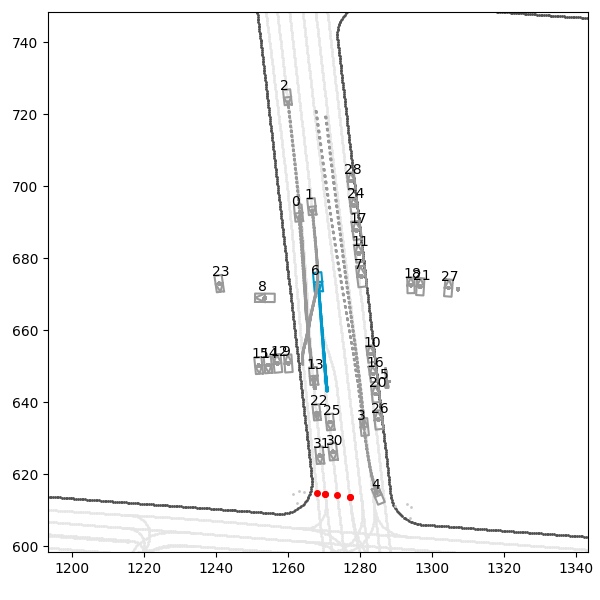

In [ ]:
# Using logged trajectory
img = visualization.plot_simulator_state(scenario, use_log_traj=True)
mediapy.show_image(img)

In [ ]:
# def test_model(model_path, test_data_path):
#    # Load the model
#    model = TrajectoryPredictor()
#    model.load_state_dict(torch.load(model_path))
#    model.eval()
#    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#    model = model.to(device)

#    # Load test data
#    test_dataset = TrajectoryDataset(test_data_path)
#    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

#    # Testing metrics
#    total_error = 0
#    predictions = []
#    ground_truths = []

#    with torch.no_grad():
#        for i, ((hist, hist_valid), (fut, fut_valid)) in enumerate(test_loader):
#            hist, fut = hist.to(device), fut.to(device)

#            # Get prediction
#            pred = model(hist)

#            # Denormalize
#            hist_denorm = test_dataset.denormalize(hist.cpu())
#            fut_denorm = test_dataset.denormalize(fut.cpu())
#            pred_denorm = test_dataset.denormalize(pred.cpu())

#            # Visualize some examples
#            if i % 10 == 0:  # Show every 10th prediction
#                plt.figure(figsize=(10, 10))
#                plt.plot(hist_denorm[0, :, 0], hist_denorm[0, :, 1], 'b-', label='History')
#                plt.plot(fut_denorm[0, :, 0], fut_denorm[0, :, 1], 'g-', label='Ground Truth')
#                plt.plot(pred_denorm[0, :, 0], pred_denorm[0, :, 1], 'r--', label='Prediction')
#                plt.legend()
#                plt.title(f'Test Sample {i}')
#                plt.grid(True)
#                plt.axis('equal')
#                plt.show()

#            # Calculate error
#            error = ((pred_denorm - fut_denorm) ** 2).mean()
#            total_error += error.item()

#            predictions.append(pred_denorm)
#            ground_truths.append(fut_denorm)

#    avg_error = total_error / len(test_loader)
#    print(f"Average test error: {avg_error:.6f}")

#    return predictions, ground_truths, avg_error

# # Example usage (update paths accordingly):
# predictions, ground_truths, avg_error = test_model('trajectory_model.pth', 'processed_data_testing/processed_uncompressed_tf_example_testing_testing_tfexample.tfrecord-00001-of-00150.npz')